According to [1] the transverse vibrational frequencies of a free standing circular plate are given by the following eigen-value equation (1):

$\frac{\lambda^2J_{n}(\lambda) + (1 - \nu)[{\lambda}J'_{n}(\lambda) - n^2J_{n}(\lambda)]}{\lambda^2I_{n}(\lambda) - (1 - \nu)[{\lambda}I'_{n}(\lambda) - n^2I_{n}(\lambda)]}$ = $\frac{\lambda^3I'_{n}(\lambda) + (1 - \nu)n^2[{\lambda}J'_{n}(\lambda) - J_{n}(\lambda)]}{\lambda^3I'_{n}(\lambda) - (1 - \nu)n^2[{\lambda}I'_{n}(\lambda) - I_{n}(\lambda)]}$

J - Bessel function of the first kind.

I - Modified Bessel function of the first kind. 

$\lambda$ - Is a unitless parameter proportional to physical constants of the system and the radius at which the vibrations are evaluated.

$\nu$ - Is Poisson's ratio.


Unfortunately, equation (1) seems to be unstable numerically (or maybe incorrect? it looks nowhere near the approximation...) and I haven't been able to compute solutions to it. However, the same reference gives an approximate version of (1), which is accurate for $\lambda >> n$. This is given as (2)


$\frac{J_n(\lambda)}{J'_n(\lambda)} = \frac{[\lambda^2 + 2(1 - \nu)n^2][I_n(\lambda)/I_n'(\lambda)] - 2\lambda(1 - \nu)}{\lambda^2 - 2(1 - \nu)n^2}$


This is the equation we solve to find the eigen-frequencies.


References:

[1] Vibration of Plates, Leissa, NASA SP-160
https://ntrs.nasa.gov/archive/nasa/casi.ntrs.nasa.gov/19700009156.pdf
equation 2.14 & 2.15

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import tabulate
import scipy.special as sps
import scipy.optimize as spo
from scipy.signal import find_peaks_cwt
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (8, 4)

In [2]:
# Insert problem parameters here:

N = [0,1,2,3] # nodal diameter number
nu = 0.33 # Poission ratio

In [3]:
# Bessel function of the first kind of order v, argument z, n'th derivative: jvp(v,z,n)
jvp = sps.jvp

# Modified Bessel function of the first kind of order v, argument z, n'th derivative: ivp(v,z,n)
ivp = sps.ivp

# Build the RHS and LHS of eq (2.14):
#noml = lambda ll, n, nu: (ll**2)*jvp(n, ll, 0) + (1 - nu)*(ll*jvp(n, ll, 1) - jvp(n, ll, 0)*n**2)
#denoml = lambda ll, n, nu: (ll**2)*ivp(n, ll, 0) - (1 - nu)*(ll*ivp(n, ll, 1) - ivp(n, ll, 0)*n**2)
#nomr = lambda ll, n, nu: (ll**3)*ivp(n, ll, 1) + (1 - nu)*(ll*jvp(n, ll, 1) - jvp(n, ll, 0))*n**2
#denomr = lambda ll, n, nu: (ll**3)*ivp(n, ll, 1) - (1 - nu)*(ll*ivp(n, ll, 1) - ivp(n, ll, 0))*n**2
#lhs = lambda ll, n, nu: noml(ll,n,nu)*denomr(ll,n,nu)
#rhs = lambda ll, n, nu: nomr(ll,n,nu)*denoml(ll,n,nu)

# Build the RHS and LHS of eq (2.15):
lhs = lambda ll, n, nu: jvp(n,ll,0)*(ll**2 - 2*(1 - nu)*n**2)
rhs = lambda ll, n, nu: jvp(n,ll,1)*((ll**2 + 2*(1 - nu)*n**2)*(ivp(n,ll,0)/ivp(n,ll,1)) - 2*ll*(1 - nu))

# And finally the eigen-value equation is lhs - rhs = 0
eigen_equation = lambda ll, n, nu: lhs(ll, n, nu) - rhs(ll, n, nu)

def solve_for_n(n):

    lam = np.linspace(1, 40, 1000)

    make_roots_pop = 1/eigen_equation(lam, n, nu)**2
    suspected_roots = find_peaks_cwt(make_roots_pop, np.arange(10, 40))

    fig = plt.figure()
    f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    ax1.plot(lam, eigen_equation(lam, n, nu))
    for x in suspected_roots:
        ax1.plot(lam[x], eigen_equation(lam[x], n, nu), 'rx')
    ax1.grid()
    ax1.set_xlim(1, 40)
    ax1.set_title('Eigen-Frequency Equation with Approximate Roots / n={} nu={}'.format(n,nu))

    ax2.semilogy(lam, make_roots_pop)
    for x in suspected_roots:
        ax2.axvline(lam[x], color='r', ls='--')
    ax2.grid()
    ax2.set_xlabel('$\lambda$')
    ax2.set_title('$1/f(\lambda)^2$ for Initial Condition Finding')
    
    return lam[suspected_roots]


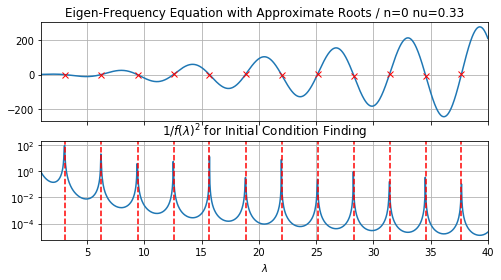

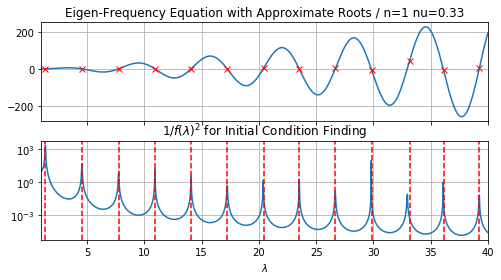

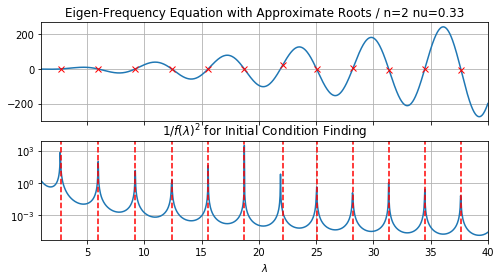

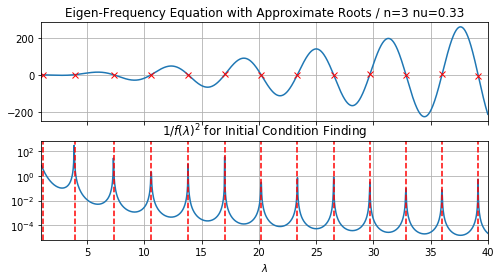

In [4]:
initial_conditions = []
for n in N:
    initial_conditions.append(solve_for_n(n))


In [5]:
# Find exact solutions using the suspected roots as initial conditions:
sols = []

for idx, ic in enumerate(initial_conditions):
    sols.append(spo.fsolve(lambda x: eigen_equation(x,N[idx],nu), ic)[0:11])

    
print('**** lambda^2 for s,n: ****')
print([len(x) for x in sols])
# Display
print(("{:^10s}|" + "{:^10d}|"*len(N)).format('s', *N))
for ind in range(11):
    print(("{:^10d}|" + "{:^10.3f}|"*len(N)).format(ind,*[ll[ind]**2 for ll in sols]))


**** lambda^2 for s,n: ****
[11, 11, 11, 11]
    s     |    0     |    1     |    2     |    3     |
    0     |  9.069   |  1.787   |  7.020   |  0.000   |
    1     |  38.507  |  20.582  |  35.415  |  14.893  |
    2     |  87.813  |  59.882  |  84.443  |  53.216  |
    3     | 156.880  | 119.020  | 153.365  | 112.024  |
    4     | 245.695  | 197.932  | 242.089  | 190.742  |
    5     | 354.253  | 296.599  | 350.585  | 289.279  |
    6     | 482.552  | 415.014  | 478.840  | 407.600  |
    7     | 630.593  | 553.174  | 626.846  | 545.688  |
    8     | 798.373  | 711.076  | 794.599  | 703.535  |
    9     | 985.893  | 888.720  | 982.097  | 881.134  |
    10    | 1193.152 | 1086.105 | 1189.339 | 1078.482 |


C:\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:161: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)
